In [1]:
RECOMBINE_DATA = False # Set to true to recombine the train and test data files
MULTICLASS = False # Set to true to enable multiclass classification
TRAIN_DATA_FILE = "UNSW_NB15_training-set.csv"
TEST_DATA_FILE = "UNSW_NB15_testing-set.csv"

In [2]:
import CS537_Project_Helper as helper

import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from category_encoders import BinaryEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight

from keras.src.optimizers import SGD
from keras.src.callbacks import LearningRateScheduler
from keras import Sequential, layers

Samples in X_train: 175341
Samples in X_test: 82332


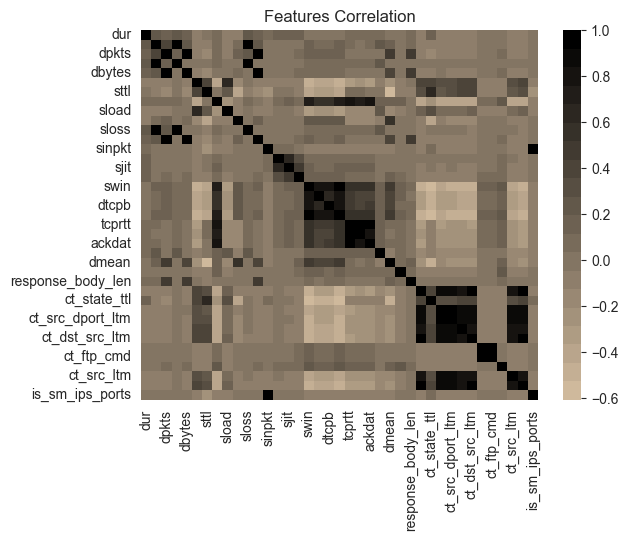

Correlated features:  sloss | sbytes | 1.0
Correlated features:  dloss | dbytes | 1.0
Correlated features:  dwin | swin | 0.99
Correlated features:  ct_ftp_cmd | is_ftp_login | 1.0
Correlated features:  ct_srv_dst | ct_srv_src | 0.98
Removed Columns {'dloss', 'sloss', 'ct_ftp_cmd', 'dwin', 'ct_srv_dst'}
Categorical features: ['proto', 'service', 'state']
Numerical features: ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_flw_http_mthd', 'ct_src_ltm', 'is_sm_ips_ports']
Number of features after preprocessing: 50


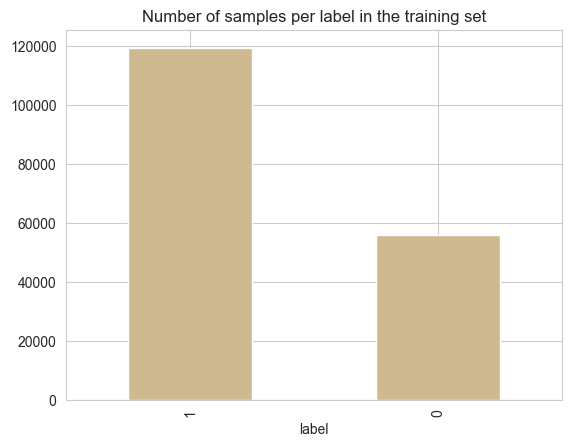

In [17]:
train_set = pd.read_csv(TRAIN_DATA_FILE).drop(columns=["id"])
test_set = pd.read_csv(TEST_DATA_FILE).drop(columns=["id"])

# Handle the creation of the X and y (train and test) data sets
# recombine the two sets first if that option is set
if RECOMBINE_DATA:
    df = pd.concat([train_set, test_set])
    X = df.drop(columns=["attack_cat", "label"])
    y = df["attack_cat"] if MULTICLASS else df["label"]
    
    # Create the test set with 30% of the total samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=True)
else:
    if MULTICLASS:
        X_train = train_set.drop(columns=["label"])
        y_train = X_train.pop("attack_cat")
        X_test = test_set.drop(columns=["label"])
        y_test = X_test.pop("attack_cat")
    else:
        X_train = train_set.drop(columns=["attack_cat"])
        y_train = X_train.pop("label")
        X_test = test_set.drop(columns=["attack_cat"])
        y_test = X_test.pop("label")
    
print(f"Samples in X_train: {len(X_train)}")
print(f"Samples in X_test: {len(X_test)}")

# Remove correlated features above 98%
helper.remove_correlated_features(X_train, X_test, threshold=0.98, display_matrix=True)

# Encode categorical features using binary encoding
# Scale numerical features using standard scaler
cat_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
num_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
print(f"Categorical features: {cat_features}")
print(f"Numerical features: {num_features}")

preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", StandardScaler(), num_features),
        ("categorical", BinaryEncoder(handle_unknown="ignore"), cat_features)
    ], sparse_threshold=0
)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print(f"Number of features after preprocessing: {X_train.shape[1]}")

# Display a graph of the class inbalance in the training data
y_train.value_counts().plot.bar(color="#CFB991")
plt.title("Number of samples per label in the training set")
plt.show()

class_labels = np.unique(y_train)
if MULTICLASS:
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

# Use class weights to balance the classes
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

## Model Training and Evaluation

Deep Neural Network

In [9]:
# Hyperparameters
epochs = 5
batch_size = 128
initial_lr = 0.01

# Function which will decrease the lr by 10% every n epochs
def lr_step_decay(epoch, lr):
    epochs_per_drop = 5
    return initial_lr * math.pow(0.9, math.floor(epoch/epochs_per_drop))

# Model
binary_model = Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(50, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(12, activation='relu'),
    layers.Dense(1),
    layers.Activation("sigmoid")
])

multiclass_model = Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(384, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(384, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(np.unique(y_train))),
    layers.Activation("softmax")
])

model = multiclass_model if MULTICLASS else binary_model
model.summary()

# Compile model
model.compile(
    optimizer = SGD(learning_rate=initial_lr, momentum=0.9),
    loss = "sparse_categorical_crossentropy" if MULTICLASS else "binary_crossentropy",
    metrics = ["accuracy"]
)

# Train model with proper callback
model.fit(X_train, y_train, validation_split=0.2, batch_size=batch_size, epochs=epochs, class_weight=class_weights, verbose=1, callbacks=[LearningRateScheduler(lr_step_decay, verbose=1)])

# Evaluate on test data
print("\nTest data loss/accuracy:")
print(model.evaluate(X_test, y_test))

# Display confusion matrix
helper.display_confusion_matrix(y_test=y_test, y_pred=np.argmax(model.predict(X_test) if MULTICLASS else model.predict(X_test).flatten() > 0.5), display_labels=class_labels)

2024-04-26 03:43:11.098248: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-04-26 03:43:11.098316: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-26 03:43:11.098327: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-26 03:43:11.098348: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-26 03:43:11.098367: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           612 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            13 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,175 (12.40 KB)

 Trainable params: 3,175 (12.40 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/5


2024-04-26 03:43:13.032068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1096/1096 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.8560 - loss: 0.3242 - val_accuracy: 0.9610 - val_loss: 0.0848 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/5
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9055 - loss: 0.1929 - val_accuracy: 0.9721 - val_loss: 0.0636 - learning_rate: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/5
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9088 - loss: 0.1805 - val_accuracy: 0.9595 - val_loss: 0.0734 - learning_rate: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/5
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9120 - loss: 0.1717 - val_accuracy: 0.9747 - val_loss: 0.0563 - learning_rate: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.01.
Epoch 5/5
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9122 - loss: 0.1684 - val_accuracy: 0.9808 - val_loss: 0.0502 - learning_rate

InvalidParameterError: The 'y_pred' parameter of confusion_matrix must be an array-like. Got 0 instead.

## Ensemble Methods

0.8733420784142253


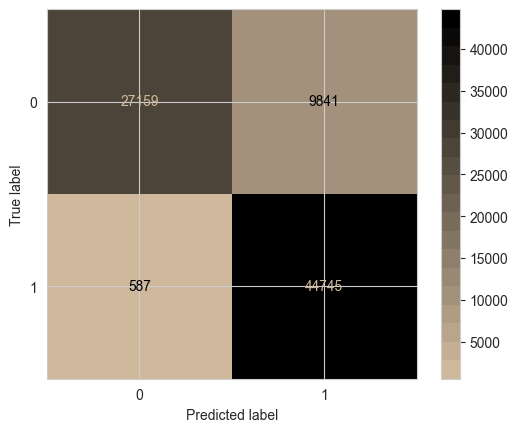

In [12]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(class_weight=class_weights).fit(X_train, y_train)
print(clf.score(X_test, y_test))
helper.display_confusion_matrix(y_pred=clf.predict(X_test), y_test=y_test, display_labels=class_labels, title="RF Confusion Matrix")

0.8784798134382743


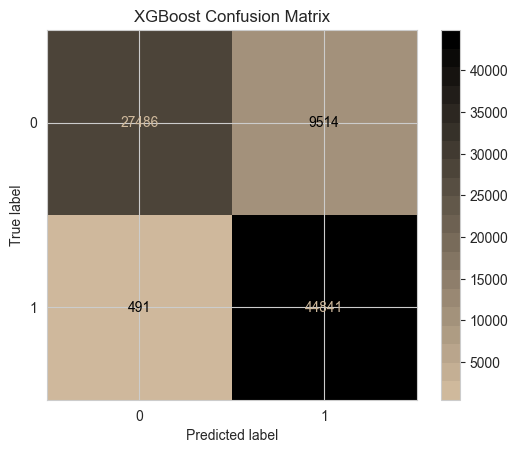

In [5]:
from xgboost import XGBClassifier

clf = XGBClassifier().fit(X_train, y_train)
print(clf.score(X_test, y_test))
helper.display_confusion_matrix(y_pred=clf.predict(X_test), y_test=y_test, display_labels=class_labels, title="XGBoost Confusion Matrix")

## Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(class_weight=class_weights).fit(X_train, y_train)
print(clf.score(X_test, y_test))
helper.display_confusion_matrix(y_pred=clf.predict(X_test), y_test=y_test, display_labels=class_labels)

<class 'numpy.int64'> <class 'numpy.int64'>


/Users/jimmy/venv-metal/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values